In [1]:
from structured.DataRetriever import DataRetriever
import numpy as np
import pandas as pd

dt = DataRetriever("D:/Descargas/i2ascii-files/i2ascii-files/", 500)
dt.set_target(['m_elev','m_az'])
dt.set_selected_hits(10)
target, data, compare_data = dt.load_data(
    get_sel_events = False,
    filter_bbfit_null = False,
    get_bbfit_data = True,
    get_aafit_data = True
)

In [2]:
# En lugar de importar la función del script utilizado en clase, se reimplementa con ligeras variaciones para
# adaptarse a las necesidades del ejercicio
def grafica_real_vs_pred_mod(y_true, y_pred, evaluated_metrics, algorithm_name):
    fig, ax = plt.subplots()
    ax.scatter(y_true, y_pred, edgecolors=(0, 0, 0))
    ax.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'k--', lw=4)
    ax.set_xlabel('Real class value')
    ax.set_ylabel('Prediction')
    title = algorithm_name + '\n'
    for name, result in evaluated_metrics.items():
        title += name + ': ' + str(round(result, 3)) + ' '
        
    plt.title(title)
    plt.show()

In [3]:
import matplotlib.pyplot as plt
from math import sqrt
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
import sklearn.metrics as metrics
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_predict, cross_validate

rand_state = 50
jobs = 6

# Métricas de evaluación que se utilizarán. No nos preocupamos en negarlas debido a que no se utilizarán de forma automática,
# solo las visualizaremos
metrics_dict = {
  'MAE': metrics.mean_absolute_error,
  'RMSE': lambda y, y_pred:
          sqrt(metrics.mean_squared_error(y, y_pred)),
  'E_VARIANCE': metrics.explained_variance_score
}

algorithms_dict = {}

# Algoritmo 1: No Outliers + Standarización + RandomForest
steps = [
    ('standardization', StandardScaler()),
    ('rforest', RandomForestRegressor(n_estimators=50, random_state=rand_state, n_jobs=jobs))]
algorithms_dict['STD_RF'] = Pipeline(steps)

In [4]:
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.3, random_state=rand_state)

D:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
D:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
D:\ProgramData\Anaconda3\lib\site-packages\sklearn\pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


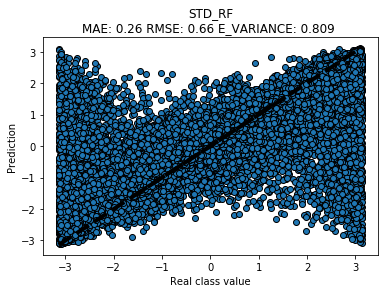

In [5]:
algorithms_dict['STD_RF'].fit(X_train, y_train)
y_pred = algorithms_dict['STD_RF'].predict(X_test)

evaluated = {}
for metric_name, metric in metrics_dict.items():
    evaluated[metric_name] = metric(y_test, y_pred)

grafica_real_vs_pred_mod(y_test, y_pred, evaluated, 'STD_RF')

In [6]:
print('BBFIT MAE: ' + str(metrics_dict['MAE'](compare_data, target)))
print('BBFIT RMSE: ' + str(metrics_dict['RMSE'](compare_data, target)))
print('BBFIT E_VARIANCE: ' + str(metrics_dict['E_VARIANCE'](compare_data, target)))

BBFIT MAE: 0.2955369833174801
BBFIT RMSE: 0.8496117170174486
BBFIT E_VARIANCE: 0.6427135461013335


In [7]:
print('STD_RF MAE: ' + str(metrics_dict['MAE'](y_pred, y_test)))
print('STD_RF RMSE: ' + str(metrics_dict['RMSE'](y_pred, y_test)))
print('STD_RF E_VARIANCE: ' + str(metrics_dict['E_VARIANCE'](y_pred, y_test)))

STD_RF MAE: 0.2601965846300568
STD_RF RMSE: 0.6598866346967223
STD_RF E_VARIANCE: 0.7595856767554079


In [5]:
from structured.OutlierDetectionTransform import OutlierDetectionTransform

outDet = OutlierDetectionTransform()
outDet.set_random_state(rand_state)
outDet.set_jobs(jobs)

In [ ]:
outDet.set_isolation_forest('auto')
iso_target, iso_data = outDet.filter_data(y_train, X_train)

algorithms_dict['STD_RF'].fit(iso_data, iso_target)
y_pred = algorithms_dict['STD_RF'].predict(X_test)

evaluated = {}
for metric_name, metric in metrics_dict.items():
    evaluated[metric_name] = metric(y_test, y_pred)

grafica_real_vs_pred_mod(y_test, y_pred, evaluated, 'STD_RF')
    
print('BBFIT ISO MAE: ' + str(metrics_dict['MAE'](y_test, y_pred)))
print('BBFIT ISO RMSE: ' + str(metrics_dict['RMSE'](y_test, y_pred)))
print('BBFIT ISO E_VARIANCE: ' + str(metrics_dict['E_VARIANCE'](y_test, y_pred)))

In [ ]:
outDet.set_elliptic_envelope(0.1, 0.9)
ell_target, ell_data = outDet.filter_data(y_train, X_train)

algorithms_dict['STD_RF'].fit(ell_data, ell_target)
y_pred = algorithms_dict['STD_RF'].predict(X_test)

evaluated = {}
for metric_name, metric in metrics_dict.items():
    evaluated[metric_name] = metric(y_test, y_pred)

grafica_real_vs_pred_mod(y_test, y_pred, evaluated, 'STD_RF')
    
print('BBFIT ELL MAE: ' + str(metrics_dict['MAE'](y_test, y_pred)))
print('BBFIT ELL RMSE: ' + str(metrics_dict['RMSE'](y_test, y_pred)))
print('BBFIT ELL E_VARIANCE: ' + str(metrics_dict['E_VARIANCE'](y_test, y_pred)))

In [ ]:
outDet.set_OCSVM(0.5, 'scale')
ocsvm_target, ocsvm_data = outDet.filter_data(y_train, X_train)

algorithms_dict['STD_RF'].fit(ocsvm_data, ocsvm_target)
y_pred = algorithms_dict['STD_RF'].predict(X_test)

for metric_name, metric in metrics_dict.items():
    evaluated[metric_name] = metric(y_test, y_pred)

grafica_real_vs_pred_mod(y_test, y_pred, evaluated, 'STD_RF')
    
print('BBFIT OCSVM MAE: ' + str(metrics_dict['MAE'](y_test, y_pred)))
print('BBFIT OCSVM RMSE: ' + str(metrics_dict['RMSE'](y_test, y_pred)))
print('BBFIT OCSVM E_VARIANCE: ' + str(metrics_dict['E_VARIANCE'](y_test, y_pred)))

In [6]:
param_grid = {'kernel_val': ['sigmoid'],
              'gamma_val': ['scale'],
              'coef0_val': [0.0, 0.2],
              'nu_val': [0.4, 0.5, 0.6]
             }

In [7]:
import itertools as it

all_params = sorted(param_grid)
combinations = it.product(*(param_grid[Name] for Name in all_params))

for l_comb in combinations:
    print(dict(zip(all_params,l_comb)))
    
    outDet.set_OCSVM(**(dict(zip(all_params,l_comb))))
    ocsvm_target, ocsvm_data = outDet.filter_data(y_train, X_train)
    
    algorithms_dict['STD_RF'].fit(ocsvm_data, ocsvm_target)
    y_pred = algorithms_dict['STD_RF'].predict(X_test)
    
    print('OCSVM SHAPE: ' + str(ocsvm_data.shape))
    print('OCSVM MAE: ' + str(metrics_dict['MAE'](y_test, y_pred)))
    print('OCSVM RMSE: ' + str(metrics_dict['RMSE'](y_test, y_pred)))
    print('OCSVM E_VARIANCE: ' + str(metrics_dict['E_VARIANCE'](y_test, y_pred)))
    print('\n\n')

{'coef0_val': 0.0, 'gamma_val': 'scale', 'kernel_val': 'sigmoid', 'nu_val': 0.4}


D:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
D:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
D:\ProgramData\Anaconda3\lib\site-packages\sklearn\pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


OCSVM SHAPE: (61857, 12)
OCSVM MAE: 0.2971751167839962
OCSVM RMSE: 0.686332080056933
OCSVM E_VARIANCE: 0.7952175074864358



{'coef0_val': 0.0, 'gamma_val': 'scale', 'kernel_val': 'sigmoid', 'nu_val': 0.5}


D:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
D:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
D:\ProgramData\Anaconda3\lib\site-packages\sklearn\pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


OCSVM SHAPE: (51549, 12)
OCSVM MAE: 0.3081580865825519
OCSVM RMSE: 0.7001855796853387
OCSVM E_VARIANCE: 0.7877001161211583



{'coef0_val': 0.0, 'gamma_val': 'scale', 'kernel_val': 'sigmoid', 'nu_val': 0.6}


D:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
D:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
D:\ProgramData\Anaconda3\lib\site-packages\sklearn\pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


OCSVM SHAPE: (41238, 12)
OCSVM MAE: 0.311549550882231
OCSVM RMSE: 0.6970113648658949
OCSVM E_VARIANCE: 0.7875057302482724



{'coef0_val': 0.2, 'gamma_val': 'scale', 'kernel_val': 'sigmoid', 'nu_val': 0.4}


D:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
D:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
D:\ProgramData\Anaconda3\lib\site-packages\sklearn\pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


OCSVM SHAPE: (48818, 12)
OCSVM MAE: 0.31070108663779833
OCSVM RMSE: 0.699827433959504
OCSVM E_VARIANCE: 0.787728485923689



{'coef0_val': 0.2, 'gamma_val': 'scale', 'kernel_val': 'sigmoid', 'nu_val': 0.5}


D:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
D:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
D:\ProgramData\Anaconda3\lib\site-packages\sklearn\pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


OCSVM SHAPE: (50368, 12)
OCSVM MAE: 0.2974312877674295
OCSVM RMSE: 0.6858526421491336
OCSVM E_VARIANCE: 0.7938892146215724



{'coef0_val': 0.2, 'gamma_val': 'scale', 'kernel_val': 'sigmoid', 'nu_val': 0.6}


D:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
D:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
D:\ProgramData\Anaconda3\lib\site-packages\sklearn\pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


OCSVM SHAPE: (41212, 12)
OCSVM MAE: 0.31107714076576526
OCSVM RMSE: 0.6955252294613204
OCSVM E_VARIANCE: 0.7881653808697233





In [ ]:
y_pred_dict = {}
for alg_name, alg in algorithms_dict.items():
    y_pred_dict[alg_name] = cross_val_predict(alg, data, target, n_jobs=jobs,
                                                              cv=KFold(n_splits=5, random_state=rand_state))
evaluated = {}
for name, prediction in y_pred_dict.items():
    for metric_name, metric in metrics_dict.items():
        evaluated[metric_name] = metric(target, prediction)

    grafica_real_vs_pred_mod(target, prediction, evaluated, name)
    
print('BBFIT MAE: ' + str(metrics_dict['MAE'](compare_data, target)))
print('BBFIT RMSE: ' + str(metrics_dict['RMSE'](compare_data, target)))
print('BBFIT E_VARIANCE: ' + str(metrics_dict['E_VARIANCE'](compare_data, target)))